In [1]:
from time import time
import pandas as pd
import numpy as np
from PIL import Image
import keras.layers.advanced_activations
import scipy
import random
import matplotlib.pyplot as plt  
from scipy.stats import norm  
import keras
from keras.models import Sequential
from keras.initializers import VarianceScaling,RandomNormal
from keras.layers import Input, Dense, Dropout, Conv2D, MaxPooling2D
from keras.layers import UpSampling2D, Reshape, Lambda, Flatten, Activation
from keras.models import Model  
from keras.optimizers import SGD, Adadelta, Adagrad,Adam
from keras import backend as K  
from keras import objectives  
from keras.utils.vis_utils import plot_model  
from keras.utils import np_utils, generic_utils
import sys 
import tensorflow as tf
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.layers.normalization import BatchNormalization
import matplotlib.pyplot as plt
import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import sklearn
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter
%matplotlib inline
from sklearn import manifold, datasets,cluster
from sklearn.utils import check_random_state

Using TensorFlow backend.


In [158]:
path = os.listdir('cstor/xsede/users/xs-haosun/SDSS_2000/')

Obj_ID = []
Image = []
Class = []
Redshift = []
for i in range(len(path)):
    path_now = path[i]
    a = np.load('cstor/xsede/users/xs-haosun/SDSS_2000/'+str(path_now))
    for j in range(a.shape[0]):
        Obj_ID.append(a[j]['objID'])
        Image.append(a[j]['image'])
        Class.append(a[j]['class'])
        Redshift.append(a[j]['z'])

Obj_ID = np.asarray(Obj_ID)
Image = np.asarray(Image)
Class = np.asarray(Class)
Redshift = np.asarray(Redshift)
Class[Class=='STAR'] = 0
Class[Class=='GALAXY'] = 1
Class[Class=='QSO'] = 2
Class = Class.astype(int)

In [159]:
Image_RGB = np.empty((len(Image),64,64,5))#(14142,64,64,3) RGB images
for i in range(len(Image)):
    #b[i] = np.stack((a[i][1][0],a[i][1][1],a[i][1][2],a[i][1][3],a[i][1][4]),axis=-1)
    Image_RGB[i] = np.stack((Image[i][4],Image[i][3],Image[i][2],Image[i][1],Image[i][0]),axis=-1)


for i in range(len(Image_RGB)):
    if True in np.isnan(Image_RGB[i]).reshape(64*64*5):
        print(i)
        Image_RGB[i][np.isnan(Image_RGB[i])==True]=np.mean(Image_RGB[i-1])

815


In [160]:
for i in range(len(Image_RGB)):
    Image_RGB[i,:,:,:] =  (Image_RGB[i,:,:,:]-np.min( Image_RGB[i,:,:,:]))/(np.max(Image_RGB[i,:,:,:])- np.min(Image_RGB[i,:,:,:]))
#Image_RGB = Image_RGB
Image_RGB = np.ones_like(Image_RGB) - Image_RGB
Image_RGB -= np.mean(Image_RGB)

In [113]:

Image_RGB =1 - ( (Image_RGB - np.min(Image_RGB))/(np.max(Image_RGB) - np.min(Image_RGB)))
Image_RGB -= np.mean(Image_RGB)
Image_RGB /= np.max(np.abs(Image_RGB))

In [161]:
label = np_utils.to_categorical(Class, 3)
data = Image_RGB
index = [i for i in range(len(data))]
#random.shuffle(index)
train_data = data[index]
train_label = label[index]
Class = Class[index]
Redshift = Redshift[index]
#show_Image_RGB = show_Image_RGB[index]
print('train_data.shape:',train_data.shape)
print('train_label.shape:',train_label.shape)

train_data.shape: (14142, 64, 64, 5)
train_label.shape: (14142, 3)


In [163]:
np.min(train_data)

-0.26538860963329142

In [164]:
batch_size =100
latent_dim = 2
nb_epoch = 50  
epsilon_std = 1.0  
intermediate_dim_1 = 600
#intermediate_dim_2 = 300
original_dim = 64*64

input_img = Input(shape=(64,64,5))

conv_1 = Conv2D(80, (3, 3), activation='tanh', padding='same',kernel_initializer='normal')(input_img)
maxpool_1 = MaxPooling2D((2, 2),  padding='same')(conv_1)

conv_2 = Conv2D(80, (3, 3), activation='tanh', padding='same',kernel_initializer='normal')(maxpool_1)
maxpool_2 = MaxPooling2D((2, 2),  padding='same')(conv_2)

conv_3 = Conv2D(80, (3, 3), activation='tanh', padding='same',kernel_initializer='normal')(maxpool_2)
maxpool_3 = MaxPooling2D((2, 2),  padding='same')(conv_3)

conv_4 = Conv2D(80, (3, 3), activation='tanh', padding='same',kernel_initializer='normal')(maxpool_3)
maxpool_4 = MaxPooling2D((2, 2),  padding='same')(conv_4)

conv_5 = Conv2D(80, (3, 3), activation='tanh', padding='same',kernel_initializer='normal')(maxpool_4)
maxpool_5 = MaxPooling2D((2, 2),  padding='same')(conv_5)

#x = Conv2D(5, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
#x = MaxPooling2D((2, 2),  padding='same')(x)

visual = Flatten()(maxpool_5)
h_1 = Dense(intermediate_dim_1, activation='relu')(visual)
#h_2 = Dense(intermediate_dim_2, activation='tanh')(h_1)

z_mean = Dense(latent_dim)(h_1)
z_log_var = Dense(latent_dim)(h_1)

def sampling(args):   
    z_mean, z_log_var = args  
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.,stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2)* epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

#h_3 = Dense(intermediate_dim_2,activation='tanh')(z)
h_4 = Dense(intermediate_dim_1,activation='relu')(z)
h_5 = Dense(80*2*2,activation='relu')(h_4)
h_6 = Reshape((2,2,80))(h_5)


conv_6 = Conv2D(80, (3, 3), activation='tanh', padding='same',kernel_initializer='normal')(h_6)
upsample_6 = UpSampling2D((2, 2))(conv_6)

conv_7 = Conv2D(80, (3, 3), activation='tanh', padding='same',kernel_initializer='normal')(upsample_6)
upsample_7 = UpSampling2D((2, 2))(conv_7)

conv_8 = Conv2D(80, (3, 3), activation='tanh', padding='same',kernel_initializer='normal')(upsample_7)
upsample_8 = UpSampling2D((2, 2))(conv_8)

conv_9 = Conv2D(80, (3, 3), activation='tanh', padding='same',kernel_initializer='normal')(upsample_8)
upsample_9 = UpSampling2D((2, 2))(conv_9)

conv_10 = Conv2D(80,  (3, 3), activation='tanh',padding='same',kernel_initializer='normal')(upsample_9)
upsample_10 = UpSampling2D((2, 2))(conv_10)

decoded = Conv2D(5, (3, 3), activation='sigmoid', padding='same')(upsample_10)

EarlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')


def vae_loss(x, decoded):  
    xent_loss = K.sum(K.sum(objectives.binary_crossentropy(x ,decoded),axis=-1),axis=-1)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1) 
    return xent_loss + 1*kl_loss  


vae = Model(inputs=input_img, outputs=decoded) 
vae.compile(optimizer='rmsprop', loss=vae_loss) 



In [183]:
vae.fit(train_data[:14000], train_data[:14000],
        shuffle=True,
        epochs=20,
        batch_size=batch_size,
        validation_data=(train_data[14000:14100],train_data[14000:14100]),callbacks=[EarlyStopping])

Train on 14000 samples, validate on 100 samples
Epoch 1/20
14000/14000 [==============================] - 32s - loss: -4866.1618 - val_loss: -4974.3237
Epoch 2/20
14000/14000 [==============================] - 32s - loss: -4866.0248 - val_loss: -4960.9810
Epoch 3/20
14000/14000 [==============================] - 32s - loss: -4866.6367 - val_loss: -4974.5957
Epoch 4/20
14000/14000 [==============================] - 32s - loss: -4866.4792 - val_loss: -4967.6631
Epoch 5/20
14000/14000 [==============================] - 32s - loss: -4867.9350 - val_loss: -4966.2510
Epoch 6/20
14000/14000 [==============================] - 32s - loss: -4865.0524 - val_loss: -4937.8467
Epoch 7/20
14000/14000 [==============================] - 32s - loss: -4868.1201 - val_loss: -4966.3643
Epoch 8/20
14000/14000 [==============================] - 32s - loss: -4867.9924 - val_loss: -4974.9907
Epoch 9/20
14000/14000 [==============================] - 32s - loss: -4867.2005 - val_loss: -4968.3213
Epoch 10/20
1400

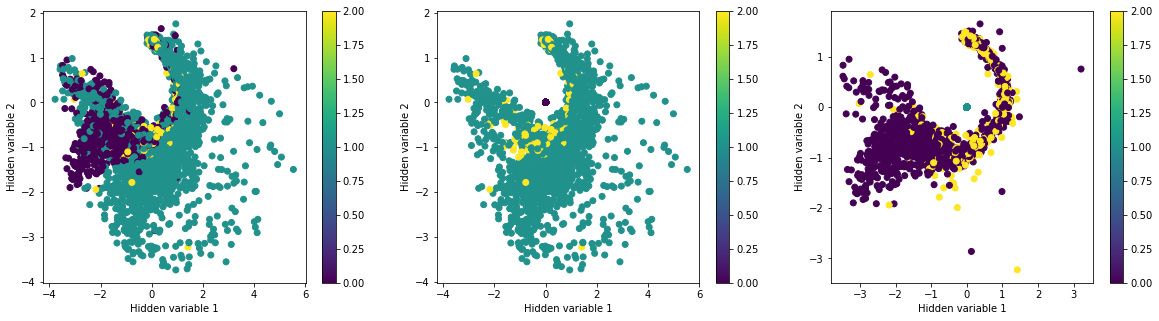

In [181]:
label_value = np.zeros(len(train_label))
for i in range(len(label_value)):
    label_value[i] =np.argmax(train_label[i])

vis = Model(input_img, z_mean)

# display a 2D plot of the digit classes in the latent space  
x_vis = vis.predict(train_data[8500:14000], batch_size=batch_size)

x_vis_1 = vis.predict(train_data[8500:14000], batch_size=batch_size)  
x_vis_1[label_value[8500:14000]<1]=0

x_vis_2 = vis.predict(train_data[8500:14000], batch_size=batch_size)  
x_vis_2[label_value[8500:14000]==1]=0

plt.figure(figsize=(20, 5))

ax = plt.subplot(1,3,1)
plt.scatter( x_vis[:, 0] ,x_vis[:, 1],c=label_value[8500:14000])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
ax = plt.subplot(1,3,2)
plt.scatter( x_vis_1[:, 0] ,x_vis_1[:, 1],c=label_value[8500:14000])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
ax = plt.subplot(1,3,3)
plt.scatter( x_vis_2[:, 0] ,x_vis_2[:, 1],c=label_value[8500:14000])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
plt.show()

In [184]:
vae.save_weights("m1to1normal_0807.h5")

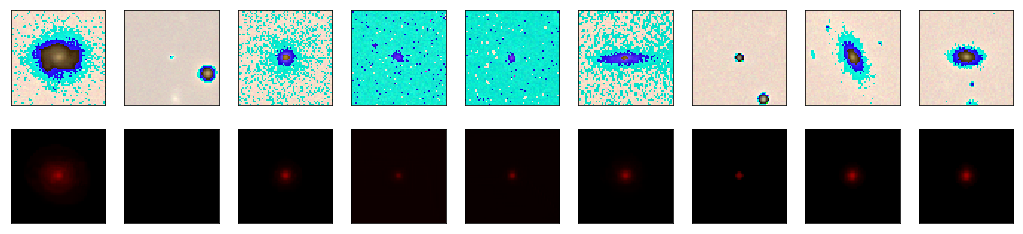

In [182]:
# encode and decode some digits
# note that we take them from the *test* set
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

#encoded_imgs = encoder.predict(x_test)

decoded_imgs = vae.predict(train_data[8000:9500],batch_size=100)

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(1,n):
    # display original
    ax = plt.subplot(2,n,i)
    plt.imshow((train_data[8000:9500][i][:,:,1:4]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n ,i + n)
    plt.imshow((decoded_imgs[i][:,:,1:4]))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [111]:
model_conv_1 = Model(input_img,conv_1)
model_pool_1 = Model(input_img,maxpool_1)
model_conv_2 = Model(input_img,conv_2)
model_pool_2 = Model(input_img,maxpool_2)
model_conv_3 = Model(input_img,conv_3)
model_pool_3 = Model(input_img,maxpool_3)
model_conv_4 = Model(input_img,conv_4)
model_pool_4 = Model(input_img,maxpool_4)
model_conv_5 = Model(input_img,conv_5)
model_pool_5 = Model(input_img,maxpool_5)
model_conv_6 = Model(input_img,conv_6)
model_up_6 = Model(input_img,upsample_6)
model_conv_7 = Model(input_img,conv_7)
model_up_7 = Model(input_img,upsample_7)
model_conv_8 = Model(input_img,conv_8)
model_up_8 = Model(input_img,upsample_8)
model_conv_9 = Model(input_img,conv_9)
model_up_9 = Model(input_img,upsample_9)
model_conv_10 = Model(input_img,conv_10)
model_up_10 = Model(input_img,upsample_10)
lyr = []
lyr.append(model_conv_1)
lyr.append(model_pool_1)
lyr.append(model_conv_2)
lyr.append(model_pool_2)
lyr.append(model_conv_3)
lyr.append(model_pool_3)
lyr.append(model_conv_4)
lyr.append(model_pool_4)
lyr.append(model_conv_5)
lyr.append(model_pool_5)
lyr.append(model_conv_6)
lyr.append(model_up_6)
lyr.append(model_conv_7)
lyr.append(model_up_7)
lyr.append(model_conv_8)
lyr.append(model_up_8)
lyr.append(model_conv_9)
lyr.append(model_up_9)
lyr.append(model_conv_10)
lyr.append(model_up_10)

In [9]:
vis = Model(input_img, z_mean)

# display a 2D plot of the digit classes in the latent space  
x_vis = vis.predict(train_data[8500:14000], batch_size=batch_size)

In [10]:
n_points = np.shape(x_vis)[0]
n_neighbors = 10
n_components = 1
isomap = manifold.Isomap(n_neighbors, n_components)
hid_pred = vis.predict(train_data, batch_size=batch_size)
Y_pred = isomap.fit_transform(hid_pred)

In [11]:
np.mean(Y_pred)

-7.850537580435275e-19

In [39]:
count_ = 0
for i in range(len(x_vis)):
    if Y_pred[8500:14000][i] >-0.009999:
        count_+=1
print("predict abs with threshold above:\n",count_/len(x_vis))
print(" %.4g" % float(np.sum(Class[Class==1])/14142*100),"%")

predict abs with threshold above:
 0.6763636363636364
 67.85 %


In [40]:
count_gala = 0
for i in range(len(hid_pred)):
    if (Y_pred[i] >-0.009999):
        if Class[i]==1:
            count_gala+=1
print(count_gala/np.sum(Class[Class==1]))
print(np.sum(Class[Class==1])-count_gala)

0.722592746978
2662


In [41]:
count_star = 0
for i in range(len(hid_pred)):
    if (Y_pred[i] <-0.009999):
        if Class[i]==0:
            count_star+=1
print(count_star/(len(hid_pred) - np.sum(Class[Class==1]) -np.sum(Class[Class==2])/2))
print((len(hid_pred) - np.sum(Class[Class==1]) -np.sum(Class[Class==2])/2)-count_star)

0.505993866741
1772.0


In [42]:
print("total accuracy is:",1-((np.sum(Class[Class==1])-count_gala)+(len(hid_pred) - np.sum(Class[Class==1]) -np.sum(Class[Class==2])/2)-count_star)/len(Y_pred))

total accuracy is: 0.686465846415
